## Validation check on CLAHE central images

authors: Tuguldur Sukhbold

In [1]:
datapath = '../../d/'
PATH2weight = '../../weights/central_ep35_small_cale.pth'

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def getInstanceSegmentationModel(num_classes):
    """
    the exact instance segmentation model used for training
    note: do not change anything here, or else weights will not properly load
    """

    # pre-trained model on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # replace the mask predictor
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


def loadTrainedModel(PATH2weights):
    """
    load the weight from given path
    """

    num_classes = 2
    model = getInstanceSegmentationModel(num_classes)
    model.load_state_dict(torch.load(PATH2weights, map_location=device))

    return model


print(device)

cpu


In [2]:
def getPlanet(fieldID):
    j17 = plt.imread(f'{datapath}planet-jun17/{fieldID}.png')
    j18 = plt.imread(f'{datapath}planet-jun18/{fieldID}.png')
    d17 = plt.imread(f'{datapath}planet-dec17/{fieldID}.png')
    d18 = plt.imread(f'{datapath}planet-dec18/{fieldID}.png')
    return j17, j18, d17, d18

def getHighContrast(j17, j18, d17, d18):
    summer = j17 + j18
    summer = summer / np.amax(summer)
    winter = d17 + d18
    winter = winter / np.amax(winter)
    diff = winter * summer
    return diff


In [3]:
def getGrayNNmask(model):
    """
    evaluation based on loaded weight
    """

    # convert image to tensor
    img   = Image.open('tmp.png').convert("RGB")
    imgT  = F.to_tensor(img)

    # evaluate
    model.eval()
    with torch.no_grad(): prediction = model([imgT.to(device)])

    # convert result back to gray image
    img = Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
    img = img.convert('L')

    return np.array(img)


def makeEnhancedImage(fieldID):
    j17, j18, d17, d18 = getPlanet(fieldID)
    img = getHighContrast(j17, j18, d17, d18)
    img = (img * 255).astype(np.uint8)
    img = Image.fromarray(img)
    img.save('tmp.png')

    img = cv.imread('tmp.png',0)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    cl1 = clahe.apply(img)
    cv.imwrite('tmp.png', cl1)



In [4]:
def getDisplacement1(mask):
    """
    based on dist to mask center
    """
    
    # just avg point for center for simple shapes
    xindx = np.where(mask > 0)[-1]
    yindx = np.where(mask > 0)[0]
    xmin, xmax = min(xindx), max(xindx)
    ymin, ymax = min(yindx), max(yindx)
    x1 = xmin + (xmax - xmin) / 2.
    y1 = ymin + (ymax - ymin) / 2.
        
    # displacement
    cX = 10.986328125 / 2
    cY = 10.985731758 / 2
    x0, y0 = mask.shape[1]//2, mask.shape[0]//2
    x = (x0-np.round(x1)) / mask.shape[1] *cX
    y = (y1-np.round(y0)) / mask.shape[0] *cY
    
    return x, y

def getDisplacement2(mask):
    """
    based on dist to closest vertex of bbox
    """
    
    # image center
    x0, y0 = mask.shape[1]//2, mask.shape[0]//2

    # bbox vertices
    xindx = np.where(mask > 0)[-1]
    yindx = np.where(mask > 0)[0]
    xmin, xmax = min(xindx), max(xindx)
    ymin, ymax = min(yindx), max(yindx)

    # vertex with min distance
    xs = np.array([xmin, xmin, xmax, xmax])
    ys = np.array([ymax, ymin, ymin, ymax])
    ds = np.sqrt((xs-x0)**2 + (ys-y0)**2)
    imin = np.where(ds == min(ds))[0][0]
    x1, y1 = xs[imin], ys[imin]
        
    # displacement
    cX = 10.986328125 / 2
    cY = 10.985731758 / 2
    x = (x0-np.round(x1)) / mask.shape[1] *cX
    y = (y1-np.round(y0)) / mask.shape[0] *cY
    
    return x, y

In [6]:
model = loadTrainedModel(PATH2weight)
train = pd.read_csv(f'{datapath}train-unique.csv')

xPred, yPred = [], []
xChk,  yChk  = [], []
for index, row in train.iterrows():
    if index > 0 and index < 367:
        fieldID = row.ID.split('_')[-1]
        makeEnhancedImage(fieldID)
        mask = getGrayNNmask(model)
        x, y = getDisplacement2(mask)
        xPred.append(x)
        yPred.append(y)
        xChk.append(row['x'])
        yChk.append(row['y'])
        print(index)

xPred = np.array(xPred)
yPred = np.array(yPred)
xChk  = np.array(xChk)
yChk  = np.array(yChk)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


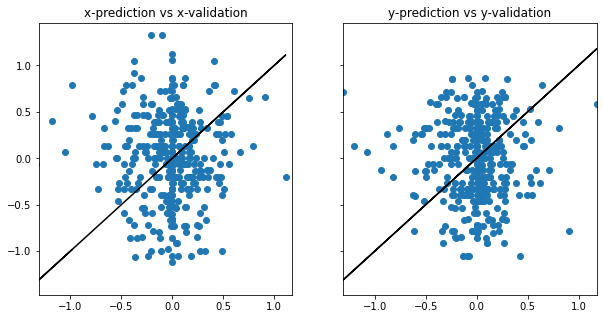

In [16]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10,5))
ax[0].scatter(xChk, xPred)
ax[0].set_title('x-prediction vs x-validation')
ax[0].set_xlim(min(xChk), max(xChk))
ax[0].plot(xChk, xChk, c='black')

ax[1].scatter(yChk, yPred)
ax[1].set_title('y-prediction vs y-validation')
ax[1].set_xlim(min(yChk), max(yChk))
ax[1].plot(yChk, yChk, c='black')
plt.show()

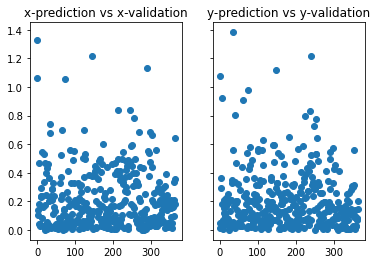

In [13]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(np.arange(len(xChk)), abs(xChk - xPred/10))
ax[0].set_title('x-prediction vs x-validation')
ax[1].scatter(np.arange(len(xChk)), abs(yChk - yPred/10))
ax[1].set_title('y-prediction vs y-validation')
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error

tst = np.column_stack((xChk, yChk))
pred = np.column_stack((xPred/100, yPred/100))

mean_absolute_error(tst, pred)

0.20306698180726035